# SC22x
 
### 코비 브라이언트의 슛 성공 여부 예측해보기

이번 스프린트 챌린지에서는 故 코비 브라이언트 선수의 NBA 필드 골 시도들이 담긴 데이터셋을 다룹니다 (1996년 11월 3일부터 2016년 4월 13일까지의 정규 시즌과 플레이오프 시즌 기록).

여러분은 각 슛의 성공 여부를 슈팅의 대한 정보, 게임에 대한 정보를 통해서 예측해야 합니다. 이것은 상당히 어려운 예측입니다. 해당 데이터셋은 [NBA API]((https://github.com/swar/nba_api) 파이썬 라이브러리를 통해 수집 됐습니다. 

In [1]:
# 데이터셋을 불러옵니다
import pandas as pd
url = 'https://ds-lecture-data.s3.ap-northeast-2.amazonaws.com/nba/nba_kobe_bryant.csv'
df = pd.read_csv(url)

# 데이터셋이 잘 불러졌는지 확인합니다
assert df.shape == (30697, 19)

In [17]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib.patches import Circle, Rectangle, Arc
from sklearn import mixture
from sklearn import ensemble
from sklearn import model_selection
from sklearn.metrics import accuracy_score as accuracy
from sklearn.metrics import log_loss
import time
import itertools
import operator


from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import Ridge
from sklearn.impute import SimpleImputer 
from sklearn.pipeline import make_pipeline
from category_encoders import OrdinalEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import f_regression, SelectKBest
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score


import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings(action='ignore')

In [3]:
from pandas_profiling import ProfileReport
profile = ProfileReport(df, minimal=True).to_notebook_iframe()

action_type : 해당 슛의 모션 정보   
game_id : 경기 식별 번호   
game_event_id : 전체 게임에서의 슛의 순번  
period : 쿼터   
minutes_remaining : 남은 시간   
seconds_remaining : 남은 초   
shot_type : 2점, 3점 슛 여부   
  
shot_zone_basic : 슛을 시도한 곳의 명칭  
shot_zone_area : 슛을 시도한 곳의 위치  
shot_zone_range :  슛을 시도한 위치에서 링까지의 거리   
shot_distance :  슛을 시도한 위치에서 링까지의 거리   
  
loc_x : 경기장의 x 좌표  
loc_y : 경기장의 y 좌표  
  
shot_made_flag : 슛 성공여부   
  
htm : 홈팀   
vtm : 원정팀  
season_type : 정규시즌, 플레이오프 



# Part 1 - Data Preprocessing

## 1.1 분류를 위한 베이스라인 정확도를 계산하세요
>예측 해야하는 target은 `shot_made_flag` 입니다. 전체 데이터를 써서 baseline **accuracy score**를 계산하세요.

In [4]:
df["shot_made_flag"].value_counts(normalize=True)[1]

0.44730755448415155

전체 데이터에 대한 baseline accuracy score : 0.4473

## 1.2 모델의 예측 정확도를 시험하기 위한 test set을 만드세요.

> 예측 모델 시험을 위해 **2014-15** ~ **2015-16** 시즌을 `test set`으로 만듭니다. NBA 시즌은 **10월**에 시작해서 **6월**에 종료합니다. 테스트셋에 **1826개**의 데이터가 있다면 알맞게 분할한 것입니다.

In [5]:
#데이터 확인
df.head(2)

,game_id,game_event_id,player_name,period,minutes_remaining,seconds_remaining,action_type,shot_type,shot_zone_basic,shot_zone_area,shot_zone_range,shot_distance,loc_x,loc_y,shot_made_flag,game_date,htm,vtm,season_type
0,29600027,102,Kobe Bryant,1,0,42,Jump Shot,2PT Field Goal,Mid-Range,Left Side Center(LC),16-24 ft.,18,-140,116,0,1996-11-03,LAL,MIN,Regular Season
1,29600031,127,Kobe Bryant,2,10,8,Jump Shot,2PT Field Goal,Mid-Range,Left Side Center(LC),16-24 ft.,16,-131,97,0,1996-11-05,NYK,LAL,Regular Season


In [6]:
#데이터 확인
df.tail(2)

,game_id,game_event_id,player_name,period,minutes_remaining,seconds_remaining,action_type,shot_type,shot_zone_basic,shot_zone_area,shot_zone_range,shot_distance,loc_x,loc_y,shot_made_flag,game_date,htm,vtm,season_type
30695,21501228,200,Kobe Bryant,2,4,56,Driving Layup Shot,2PT Field Goal,Restricted Area,Center(C),Less Than 8 ft.,0,6,-5,1,2016-04-13,LAL,UTA,Regular Season
30696,21501228,72,Kobe Bryant,1,4,14,Driving Reverse Layup Shot,2PT Field Goal,Restricted Area,Center(C),Less Than 8 ft.,2,-17,-11,1,2016-04-13,LAL,UTA,Regular Season


In [7]:
df['year'] = pd.DatetimeIndex(df['game_date']).year

In [8]:
condition = (df["year"] >= 2014 ) & ( df["year"] < 2017 )
train = df[condition]
train.shape

(1826, 20)

## 1.3 새로운 feature를 만드세요

> 최소 1개 이상의 새로운 feature를 만드세요. 아래의 리스트를 사용하셔도 되고 스스로의 아이디어로 만들어 주셔도 괜찮습니다.
>- **Homecourt Advantage**: 홈 팀(`htm`)이 Los Angeles Lakers (`LAL`)인지 여부
>- **Opponent**: LA Lakers를 상대하는 팀을 나타내는 feature
>- **Seconds remaining in the period**: 피리어드에 남은 총 시간 (분과 초를 합칩니다)
>- **Seconds remaining in the game**: 게임에 남은 총 시간 (피리어드와 초를 합칩니다). 농구에서 게임은 총 4개의 피리어드로 이루어져 있습니다 (각 12분)
>- **Made previous shot**: 코비 브라이언트의 예전 슛이 성공했는지 여부
    

In [9]:
df.columns

Index(['game_id', 'game_event_id', 'player_name', 'period',
       'minutes_remaining', 'seconds_remaining', 'action_type', 'shot_type',
       'shot_zone_basic', 'shot_zone_area', 'shot_zone_range', 'shot_distance',
       'loc_x', 'loc_y', 'shot_made_flag', 'game_date', 'htm', 'vtm',
       'season_type', 'year'],
      dtype='object')

일단 가장 비슷한 시간의 데이터는 더해주도록 하겠습니다. 

1) 단위 통일 후 더해주도록 하겠습니다.  


In [10]:
df['seconds_all_time']   = 60*df['minutes_remaining']+df['seconds_remaining']

In [11]:
df['seconds_all_time']
df.head(2)

,game_id,game_event_id,player_name,period,minutes_remaining,seconds_remaining,action_type,shot_type,shot_zone_basic,shot_zone_area,...,shot_distance,loc_x,loc_y,shot_made_flag,game_date,htm,vtm,season_type,year,seconds_all_time
0,29600027,102,Kobe Bryant,1,0,42,Jump Shot,2PT Field Goal,Mid-Range,Left Side Center(LC),...,18,-140,116,0,1996-11-03,LAL,MIN,Regular Season,1996,42
1,29600031,127,Kobe Bryant,2,10,8,Jump Shot,2PT Field Goal,Mid-Range,Left Side Center(LC),...,16,-131,97,0,1996-11-05,NYK,LAL,Regular Season,1996,608


## 1.4 모델을 어떻게 검증할지 결정한 후에 데이터셋을 분할하세요. 

>아래의 검증 방법 중 하나를 선택한 후 목적에 맞게 데이터를 분할 하세요. 어떤 방법을 선택하는지 여부로 채점되지 않습니다 (두 방법 모두 좋은 방법입니다).
>
>- **Train/validate/test split을 통한 검증 (Hold-out Validation): 무작위로 80/20% 비율로 나누기**
>- **독립적인 test set으로 Cross-validation을 통한 검증**. scikit-learn에 있는 모든 cross-validation 방법을 활용하셔도 됩니다.

In [12]:
X = df.drop(["shot_made_flag", "game_date", "game_id"], axis=1)
y = df[["shot_made_flag"]]
X_train_all, X_test, y_train_all, y_test = train_test_split(X, y, stratify=y, test_size=0.2, random_state=42)

# 검증세트 분할하기
X_train, X_val, y_train, y_val = train_test_split(X_train_all, y_train_all, stratify=y_train_all, test_size=0.2, random_state=42)

# 데이터 분할 확인 
print(X_train_all.shape, X_test.shape, y_train_all.shape, y_test.shape)
print(X_train.shape, X_val.shape, y_train.shape, y_val.shape)

(24557, 18) (6140, 18) (24557, 1) (6140, 1)
(19645, 18) (4912, 18) (19645, 1) (4912, 1)


# Part 2 - Modeling & Evaluation

## 2.1 범주형 feature를 인코딩하고 DecisionTree 혹은 RandomForest를 이용한 학습까지 완료하는 파이프라인을 구축하세요
>Scikit-learn의 `pipeline`을 활용합니다.

In [13]:
# (참고) warning 제거를 위한 코드
np.seterr(divide='ignore', invalid='ignore')

pipe = make_pipeline(
    OrdinalEncoder(), 
    SimpleImputer(), 
    RandomForestClassifier(n_estimators=1000, 
                           max_depth=15, 
                           max_features=0.4, 
                           min_samples_leaf=15, 
                           random_state=42, 
                           n_jobs=-1, 
                           oob_score=True)
)

pipe.fit(X_train, y_train)

k = 5
scores = cross_val_score(pipe, X_train, y_train, cv=k)


print('교체 검증 train 정확도', scores.mean())

교체 검증 train 정확도 0.678951387121405


## 2.2 검증셋을 사용해서 모델의 예측 정확도(accuracy score)를 계산하세요.
>1.4에서 Cross-validation으로 진행한 경우는 그냥 cv score를 작성하세요.

In [14]:
scores = cross_val_score(pipe, X_val, y_val, cv=k)

print('교체 검증 val 정확도', scores.mean())

교체 검증 val 정확도 0.6726395567830304


In [15]:
y_pred = pipe.predict(X_val)
print('검증 정확도: ', accuracy(y_val, y_pred))

검증 정확도:  0.6763029315960912


In [22]:
print('검증세트 정확도', pipe.score(X_val, y_val))
print('검증세트 f1 score', f1_score(y_val, pipe.predict(X_val)))

검증세트 정확도 0.6763029315960912
검증세트 f1 score 0.5658110322228291


## 2.3 테스트셋을 사용해서 모델의 예측 정확도(accuracy score)를 계산하세요

In [19]:
scores = cross_val_score(pipe, X_train_all, y_train_all, cv=k)

print('교체 검증 X_train_all 정확도', scores.mean())

교체 검증 X_train_all 정확도 0.6755709196996439


In [20]:
scores = cross_val_score(pipe, X_test, y_test, cv=k)

print('교체 검증 test 정확도', scores.mean())

교체 검증 test 정확도 0.6871335504885994


In [21]:
print('훈련세트 정확도', pipe.score(X_train, y_train))
print('훈련세트 f1 score', f1_score(y_train, pipe.predict(X_train)))

훈련세트 정확도 0.7130058539068466
훈련세트 f1 score 0.6106353591160221


# Part 3 - Confusion Matrix
### 다음 confusion matrix를 사용해서 accuracy, precision, recall을 계산하세요. 아래의 테이블이 이진분류 모델의 confusion matrix라고 생각하고 계산하세요.

<table>
  <tr>
    <td colspan="2" rowspan="2"></td>
    <td colspan="2" align='center'><b>Predicted</b></td>
  </tr>
  <tr>
    <td>Negative</td>
    <td>Positive</td>
  </tr>
  <tr>
      <td rowspan="2"><b>Actual</b></td>
    <td>Negative</td>
    <td style="border: solid" align='center'>85</td>
    <td style="border: solid" align='center'>58</td>
  </tr>
  <tr>
    <td>Positive</td>
    <td style="border: solid" align='center'>8</td>
    <td style="border: solid" align='center'> 36</td>
  </tr>
</table>

### a) Accuracy score를 계산하세요

정확도 : (TP + TN) / total

In [25]:
tp = 36
tn = 85
fp = 58
fn = 8

In [26]:
total = tp + tn + fp + fn 
print("accuracy : ", (tp+tn)/total)

accuracy :  0.6470588235294118


### b) Precision score를 계산하세요 

정밀도 : tp / (tp +fp)

In [27]:
print("precision :", tp / (tp +fp))

precision : 0.3829787234042553


### c) Recall score를 계산하세요

재현율 : tp / ( tp+fn )

In [28]:
print("recall :", tp / ( tp+fn ))

recall : 0.8181818181818182


# Advanced Goals
>**3점**을 획득하기 위해선 아래의 **"모든 조건"**을 만족해야합니다. 
- **4개** 이상의 새로운 feature들을 만드세요. 1.3에 있는 feature들을 포함해서 만드셔도 괜찮습니다.
- `feature들`과 `target`의 관계를 보여주는 시각화를 **2개** 이상 해주세요.
- 최소 3개의 하이퍼 파라미터를 사용해서 가능한 조합이 10개 이상이 되도록해서 최적화 하세요.`RandomizedSearchCV`나 `GridSearchCV`를 사용하거나 임의로 조합을 만들어도 상관 없습니다.
- `feature importance`를 계산하고 시각화 해주세요.

# 1. Add features

In [29]:
df.head(2)

,game_id,game_event_id,player_name,period,minutes_remaining,seconds_remaining,action_type,shot_type,shot_zone_basic,shot_zone_area,...,shot_distance,loc_x,loc_y,shot_made_flag,game_date,htm,vtm,season_type,year,seconds_all_time
0,29600027,102,Kobe Bryant,1,0,42,Jump Shot,2PT Field Goal,Mid-Range,Left Side Center(LC),...,18,-140,116,0,1996-11-03,LAL,MIN,Regular Season,1996,42
1,29600031,127,Kobe Bryant,2,10,8,Jump Shot,2PT Field Goal,Mid-Range,Left Side Center(LC),...,16,-131,97,0,1996-11-05,NYK,LAL,Regular Season,1996,608


In [30]:
df =  df[pd.notnull(df['shot_made_flag'])]

## 담당자가 생각했을 때 슛을한 거리, 슛을 한 지역, 슛 동작이 해당 데이터에서는 중요한 featur로 생각이 된다. 
## 이에, 일단 본 데이터로 진행을 하고 생각했던 것보다 중요한 feature가 아닐 경우, 추가적인 EDA를 진행하고자한다. 

새로운 feature1 = 농구를 하다보면 특정 쿼더나 시간에 집중력이 높은 선수들이 있을것으로 사료되었다. 이에, 그 시간을 학습시키고 가중치기 위해 해당 데이터를 더해주었다. 

In [31]:
df['seconds_all_time']   = 60*df['minutes_remaining']+df['seconds_remaining']

새로운 feature2 = 또한 사람의 바이오흐름은 기간을 가지고 변화하는데 보통 주단위로 움직이게 된다. 그렇다면 컨디션이 좋은 주차에는 더 좋은 흐름을 보이지 않았을까? 생각되어 주단위로 나우어서 데이터를 학습시켜보고자 한다. 

In [32]:
df['date_split'] = pd.to_datetime(df['game_date'])
df['Week']    = df['date_split'].dt.dayofweek

새로운 feature3 =  각 선수마다 전성기가 분명있을 것으로 사료된다. 보통 선수들은 연도별로 전성기를 나누기에 연도를 구분시켜주어 학습시키고자 한다.  

In [33]:
df['Year']    = df['date_split'].dt.dayofyear

새로운 feature4 = 홈일 때 선수들은 더 좋은 성적을 보이는 경향이 있어서 해당 데이터를 추가해주었습니다. 

In [34]:
condition = [(df["htm"]  == "LAL"), (df["htm"]  != "LAL")]
con_data = [1, 0]
df["advantis"] = np.select(condition, con_data, default='Not Specified')
df.head(2)

,game_id,game_event_id,player_name,period,minutes_remaining,seconds_remaining,action_type,shot_type,shot_zone_basic,shot_zone_area,...,game_date,htm,vtm,season_type,year,seconds_all_time,date_split,Week,Year,advantis
0,29600027,102,Kobe Bryant,1,0,42,Jump Shot,2PT Field Goal,Mid-Range,Left Side Center(LC),...,1996-11-03,LAL,MIN,Regular Season,1996,42,1996-11-03,6,308,1
1,29600031,127,Kobe Bryant,2,10,8,Jump Shot,2PT Field Goal,Mid-Range,Left Side Center(LC),...,1996-11-05,NYK,LAL,Regular Season,1996,608,1996-11-05,1,310,0


In [35]:
df = df.drop(["date_split"], axis=1)

In [36]:
X = df.drop(["shot_made_flag", "game_date", "game_id"], axis=1)
y = df[["shot_made_flag"]]
X_train_all, X_test, y_train_all, y_test = train_test_split(X, y, stratify=y, test_size=0.2, random_state=42)

# 검증세트 분할하기
X_train, X_val, y_train, y_val = train_test_split(X_train_all, y_train_all, stratify=y_train_all, test_size=0.2, random_state=42)

# 데이터 분할 확인 
print(X_train_all.shape, X_test.shape, y_train_all.shape, y_test.shape)
print(X_train.shape, X_val.shape, y_train.shape, y_val.shape)

(24557, 21) (6140, 21) (24557, 1) (6140, 1)
(19645, 21) (4912, 21) (19645, 1) (4912, 1)


In [37]:
from sklearn.model_selection import RandomizedSearchCV
pipe = make_pipeline(OrdinalEncoder(), SimpleImputer(), 
                             RandomForestClassifier(criterion='entropy',
                                                    n_jobs=-1,
                                                    oob_score=True
                                                    )
  )

parameters = {'randomforestclassifier__n_estimators': [100, 500, 1000], 
               'randomforestclassifier__min_samples_leaf': [5,10,15],
              'randomforestclassifier__max_depth': [5,10,15]}


clf = RandomizedSearchCV(
    pipe, 
    param_distributions=parameters, 
    n_iter=50, 
    cv=3, 
    scoring='f1',  
    verbose=1,
    n_jobs=-1
)

clf.fit(X_train, y_train);

Fitting 3 folds for each of 27 candidates, totalling 81 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:   12.1s
[Parallel(n_jobs=-1)]: Done  81 out of  81 | elapsed:   57.1s finished


# 2. 최적화 

( 시각화 후 최적화를 하면 오류가 발생되어 위로 올렸습니다.  )

In [38]:
print('최적 하이퍼파라미터: ', clf.best_params_)

최적 하이퍼파라미터:  {'randomforestclassifier__n_estimators': 1000, 'randomforestclassifier__min_samples_leaf': 10, 'randomforestclassifier__max_depth': 15}


### 10개 이상의 다른 하이퍼파라미터 조합에 따른 데이터프레임

In [39]:
# rank_test_score: 테스트 순위
# mean_score_time: 예측에 걸리는 시간
pd.DataFrame(clf.cv_results_).sort_values(by='rank_test_score').T

,23,24,0,5,12,22,19,17,2,25,...,21,6,7,13,14,16,10,18,15,9
mean_fit_time,15.2505,4.81445,0.750664,13.0219,2.96798,12.8856,10.7213,15.999,13.1051,7.38865,...,5.12022,2.50425,6.85152,9.46545,15.4722,8.35284,8.49496,2.15843,2.75128,1.69483
std_fit_time,0.389476,0.302748,0.0230128,0.717394,0.443604,3.20315,1.9964,0.497305,0.266004,0.615577,...,1.67331,1.65339,0.323603,0.74636,0.974109,0.253034,0.049129,0.51331,0.785916,0.438173
mean_score_time,1.67697,1.52169,0.243549,1.7294,1.78493,1.9054,2.89507,2.74812,1.24749,1.87209,...,3.34115,0.531843,0.951844,2.20665,2.9503,1.45164,1.9544,1.62232,1.77559,0.86877
std_score_time,0.902636,0.470957,0.032125,0.135059,1.14332,0.527947,1.99898,1.44639,0.202277,1.01075,...,2.28811,0.505088,0.646202,0.874428,0.365628,0.326543,1.21132,1.42342,0.784439,0.457006
param_randomforestclassifier__n_estimators,1000,100,100,1000,100,500,500,1000,1000,500,...,100,100,500,500,1000,500,500,100,100,100
param_randomforestclassifier__min_samples_leaf,10,15,5,10,10,10,5,15,5,15,...,10,15,15,10,10,15,5,5,15,5
param_randomforestclassifier__max_depth,15,15,5,5,10,15,15,10,5,15,...,15,5,5,10,10,10,10,15,10,10
params,"{'randomforestclassifier__n_estimators': 1000,...","{'randomforestclassifier__n_estimators': 100, ...","{'randomforestclassifier__n_estimators': 100, ...","{'randomforestclassifier__n_estimators': 1000,...","{'randomforestclassifier__n_estimators': 100, ...","{'randomforestclassifier__n_estimators': 500, ...","{'randomforestclassifier__n_estimators': 500, ...","{'randomforestclassifier__n_estimators': 1000,...","{'randomforestclassifier__n_estimators': 1000,...","{'randomforestclassifier__n_estimators': 500, ...",...,"{'randomforestclassifier__n_estimators': 100, ...","{'randomforestclassifier__n_estimators': 100, ...","{'randomforestclassifier__n_estimators': 500, ...","{'randomforestclassifier__n_estimators': 500, ...","{'randomforestclassifier__n_estimators': 1000,...","{'randomforestclassifier__n_estimators': 500, ...","{'randomforestclassifier__n_estimators': 500, ...","{'randomforestclassifier__n_estimators': 100, ...","{'randomforestclassifier__n_estimators': 100, ...","{'randomforestclassifier__n_estimators': 100, ..."
split0_test_score,0.563497,0.564177,0.565298,0.565719,0.566646,0.56355,0.561542,0.564876,0.56631,0.562448,...,0.559917,0.566248,0.563351,0.562643,0.564857,0.563018,0.562812,0.557684,0.560864,0.562797
split1_test_score,0.567546,0.569641,0.565991,0.565458,0.565475,0.566375,0.569692,0.565253,0.565404,0.566321,...,0.565624,0.56593,0.566299,0.565669,0.563622,0.563789,0.562845,0.56557,0.566299,0.561821


In [40]:
pipe = clf.best_estimator_

In [41]:
scores_before = cross_val_score(pipe, X_train, y_train)
scores_after = cross_val_score(pipe, X_val, y_val)

print('정확도', scores_before.mean())
print('정확도', scores_after.mean())

정확도 0.6770170526851617
정확도 0.6742686774970837


In [42]:
scores = cross_val_score(pipe, X_val, y_val, cv=3)
scores = cross_val_score(pipe, X_test, y_test, cv=3)

훈련 및 검증때보다는 성적이 좋게 나옴을 확인하였습니다. 

In [43]:
scores.mean()

0.6884377124539753

In [44]:
feature_importance = clf.best_estimator_._final_estimator.feature_importances_

In [45]:
feature_importance

array([0.06865276, 0.        , 0.01533432, 0.02886437, 0.0597241 ,
       0.26767713, 0.00671396, 0.01856407, 0.01532693, 0.01477173,
       0.06459424, 0.0584631 , 0.07355022, 0.03815996, 0.03734855,
       0.00431898, 0.05174975, 0.07373417, 0.02787571, 0.06518629,
       0.00938965])

In [46]:
df = df.drop(["shot_made_flag", "game_date", "game_id"],axis =1)

In [47]:
list = df.columns

In [48]:
df_feature_importance = pd.DataFrame(feature_importance, index=list,  columns=['feature importance']).sort_values('feature importance', ascending=True)
df_feature_importance

,feature importance
player_name,0.000000
season_type,0.004319
shot_type,0.006714
advantis,0.009390
shot_zone_range,0.014772
shot_zone_area,0.015327
period,0.015334
shot_zone_basic,0.018564
Week,0.027876
minutes_remaining,0.028864


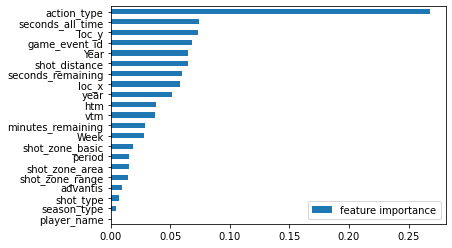

In [49]:
df_feature_importance.plot(kind='barh');

## 초기 예상대로 슛동작, 거리 등이 매우 중요한 feature로 확인되었다.   
## 이에, 추가적인 EDA는 진행하지 않고자 합니다. 

# 3. 시각화

In [50]:
# 데이터셋을 불러옵니다
import pandas as pd
url = 'https://ds-lecture-data.s3.ap-northeast-2.amazonaws.com/nba/nba_kobe_bryant.csv'
df = pd.read_csv(url)

# 데이터셋이 잘 불러졌는지 확인합니다
assert df.shape == (30697, 19)

In [51]:
df1 = df[["game_date", "shot_distance"]]

In [52]:
df1.set_index("game_date", inplace=True)

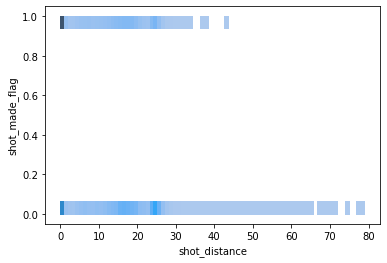

In [53]:
sns.histplot(x="shot_distance", y="shot_made_flag", data=df);
# 근거리에서 높은 적정률이 관찰됨 

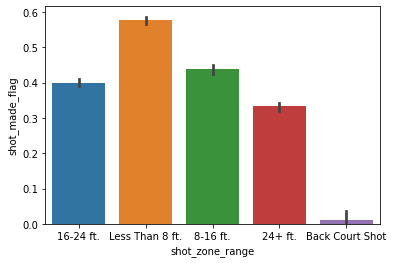

In [54]:
sns.barplot(x="shot_zone_range", y="shot_made_flag", data=df);
# Less than 8ft에서 가장 높은 적정률이 관찰됨 

<AxesSubplot:xlabel='period', ylabel='shot_made_flag'>

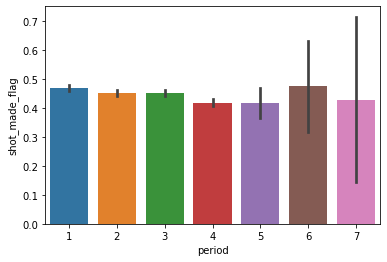

In [55]:
sns.barplot(x="period", y="shot_made_flag", data=df)
# 저의 예상과는 다르게 period에 따른 특이점은 발견되지 않았으며, 이 선수가 고르게 경기를 뛴 것으로 관측됨

Text(0.5, 1.0, 'loc_x and loc_y')

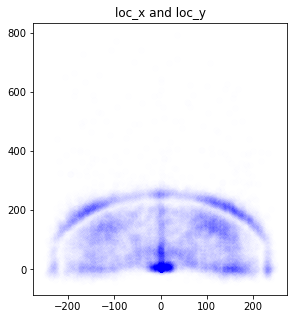

In [56]:
alpha = 0.002
plt.figure(figsize=(10,5))

# loc_x and loc_y
plt.subplot(121)
plt.scatter(df.loc_x, df.loc_y, color='blue', alpha=alpha)
plt.title('loc_x and loc_y')

# 코드를 그려서 확인해 보니 더욱더 골밑에서의 활약이 두드러져서 관찰됨 